In [17]:
from azureml.core import Workspace, Dataset

ws = Workspace.from_config()

dataset = Dataset.get_by_name(ws, name='MouvementData')
df = dataset.to_pandas_dataframe()
df = df[(df['activityType']!="Monter") & (df['activityType']!="Descendre")]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109034 entries, 60548 to 176546
Data columns (total 9 columns):
userId          109034 non-null int64
dX-acc          109034 non-null float64
dY-acc          109034 non-null float64
dZ-acc          109034 non-null float64
dX-gyr          109034 non-null float64
dY-gyr          109034 non-null float64
dZ-gyr          109034 non-null float64
time            109034 non-null float64
activityType    109034 non-null object
dtypes: float64(7), int64(1), object(1)
memory usage: 8.3+ MB


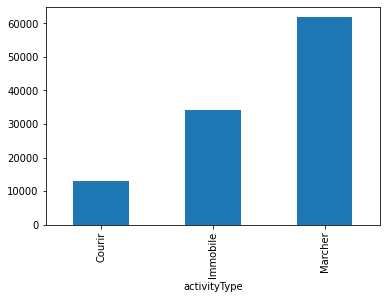

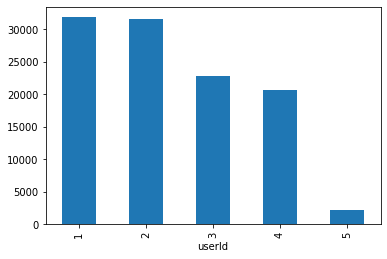

In [19]:
from matplotlib import pyplot as plt
# Show how many training examples exist for each activity
df.groupby('activityType').size().plot(kind='bar')
plt.show()
# Show how many training examples exist for each user
df.groupby('userId').size().plot(kind='bar')
plt.show()

In [20]:
#Prepare features and labels sample
X = df.drop(columns=['userId', 'activityType', 'time'])
y = df['activityType']

print('Taille du jeu de données X : ', X.shape)
print('Taille du jeu de données y : ', y.shape)

Taille du jeu de données X :  (109034, 6)
Taille du jeu de données y :  (109034,)


In [21]:
#Encode the label with Interger instead of String
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df['activityType'].unique())
y = le.transform(y)
labels = list(le.classes_)

In [22]:
print(labels)

['Courir', 'Immobile', 'Marcher']


In [23]:
#Normalize the data
from sklearn.preprocessing import MaxAbsScaler

transformer = MaxAbsScaler().fit(X)
X = transformer.transform(X)

In [24]:
import numpy as np

print(X[0:5],"\n")
print(np.unique(y, return_counts=True))

[[ 0.          0.          0.         -0.17910858 -0.03432739  0.0487458 ]
 [ 0.04218173  0.06975182  0.09942368 -0.17910858 -0.03432739  0.0487458 ]
 [ 0.04218173  0.06975182  0.09942368  0.12828162  0.03461275  0.05829915]
 [ 0.04218173  0.06975182  0.09942368  0.12828162  0.03461275  0.05829915]
 [ 0.04218173  0.06975182  0.09942368  0.12828162  0.03461275  0.05829915]] 

(array([0, 1, 2]), array([13125, 34123, 61786]))


In [25]:
from sklearn.model_selection import train_test_split

test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)#shuffle=False

In [26]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [27]:
clf = lgb.LGBMClassifier(max_depth=10,
                        learning_rate=0.03,
                        objective='multiclass',
                        n_estimators=5000)

clf.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['multi_logloss'],
        early_stopping_rounds=5)

[1]	valid_0's multi_logloss: 0.90422
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 0.871331
[3]	valid_0's multi_logloss: 0.840702
[4]	valid_0's multi_logloss: 0.812061
[5]	valid_0's multi_logloss: 0.785179
[6]	valid_0's multi_logloss: 0.759881
[7]	valid_0's multi_logloss: 0.735983
[8]	valid_0's multi_logloss: 0.713396
[9]	valid_0's multi_logloss: 0.691978
[10]	valid_0's multi_logloss: 0.671569
[11]	valid_0's multi_logloss: 0.652121
[12]	valid_0's multi_logloss: 0.633693
[13]	valid_0's multi_logloss: 0.616212
[14]	valid_0's multi_logloss: 0.599529
[15]	valid_0's multi_logloss: 0.583606
[16]	valid_0's multi_logloss: 0.568315
[17]	valid_0's multi_logloss: 0.553655
[18]	valid_0's multi_logloss: 0.539639
[19]	valid_0's multi_logloss: 0.526212
[20]	valid_0's multi_logloss: 0.513296
[21]	valid_0's multi_logloss: 0.50095
[22]	valid_0's multi_logloss: 0.489053
[23]	valid_0's multi_logloss: 0.477616
[24]	valid_0's multi_logloss: 0.466584
[25]	valid_0's 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.03, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=5000, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

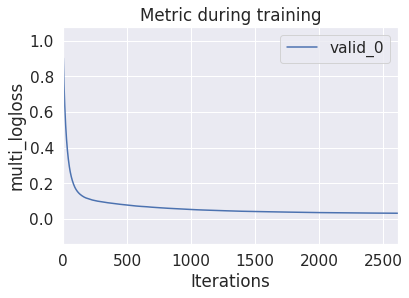

In [31]:
lgb.plot_metric(clf)

In [32]:
if(hasattr(clf, 'best_iteration')) :
    y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
else :
    y_pred = clf.predict(X_test, num_iteration=3000)

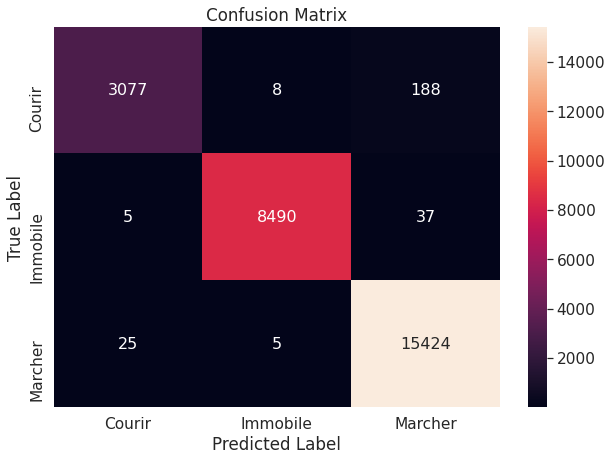

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3273
           1       1.00      1.00      1.00      8532
           2       0.99      1.00      0.99     15454

    accuracy                           0.99     27259
   macro avg       0.99      0.98      0.98     27259
weighted avg       0.99      0.99      0.99     27259



In [33]:
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

matrix = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix, labels, labels)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d") # font size

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(classification_report(y_test, y_pred))

In [16]:
#création d'une classe qui encapsule le modèle et le scaller
class BionelessModel:
    
    def __init__(self, model, transformer, preproces):
        self.model = model
        self.transformer = transformer
        self.preproces = preproces
        
    def predict(self, data):
        return self.model.predict(data, num_iteration=800)
    
    def transform(self, data):
        return self.transformer.transform(data)
    
    def translate_prediction(self, prediction):
        return self.preproces.inverse_transform(prediction)
    
    def prepareData(self, data):
        data = data.drop(columns=['userId', 'activityType', 'time'])
        data = self.transform(data)
        return data
    
bionelessModel = BionelessModel(clf, transformer, le)

In [34]:
import pickle

with open('bionelessModel.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
from azureml.core.model import Model

# Register model
model = Model.register(workspace = ws,
                        model_path ="bionelessModel.pkl",
                        model_name = "bionelessModel_SWR",)

Registering model bionelessModel_SWR


In [35]:
with open('transformer.pkl', 'wb') as f:
    pickle.dump(transformer, f)
    
model = Model.register(workspace = ws,
                        model_path ="transformer.pkl",
                        model_name = "transformer_SWR",)

Registering model transformer_SWR


In [36]:
with open('translater.pkl', 'wb') as f:
    pickle.dump(le, f)
    
model = Model.register(workspace = ws,
                        model_path ="translater.pkl",
                        model_name = "translater_SWR",)

Registering model translater_SWR


# Testing on a new subject

In [17]:
datastore = ws.get_default_datastore()
dataDirectory = "MouvementData"

filesDownloaded = datastore.download(dataDirectory, overwrite=False, show_progress=True)
print("Nombre de fichier téléchargé : %d" % filesDownloaded)

Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-07-08.csv
Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-08-29.csv
Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-10-39.csv
Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-11-47.csv
Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-13-22.csv
Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-14-32.csv
Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-17-18.csv
Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-18-58.csv
Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-20-58.csv
Path already exists. Skipping download for MouvementData/MouvementData-15-02-2021 11-22-24.csv
Path already exists. Skipping download for Mouveme

Nombre de fichier téléchargé : 0


In [19]:
file = "test.csv"
path = os.path.join("axel.carnez", file)
newData = pd.read_csv(path, delimiter=",")

newData = bionelessModel.prepareData(newData)

In [20]:
new_prediction = bionelessModel.predict(newData)

In [21]:
new_prediction_translate = bionelessModel.translate_prediction(new_prediction)
print(new_prediction_translate)

['Immobile' 'Immobile' 'Immobile' 'Immobile' 'Immobile' 'Immobile'
 'Immobile' 'Immobile' 'Immobile' 'Immobile' 'Immobile' 'Immobile'
 'Immobile' 'Immobile' 'Immobile' 'Immobile' 'Immobile' 'Immobile'
 'Immobile']


In [22]:
label, nb = np.unique(new_prediction_translate, return_counts=True)
print(label, nb)

['Immobile'] [19]


In [23]:
pourcentage_reussite = (nb[1]*100)/(nb[0]+nb[1]+nb[3]+nb[2]+nb[4])
print(pourcentage_reussite)

IndexError: index 1 is out of bounds for axis 0 with size 1